In [18]:
import os
import subprocess
from pathlib import Path

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import skimage
import tifffile
from einops import rearrange
from ome_types import from_tiff, from_xml, to_xml, OME
from ome_types.model import Image, Pixels, Channel
from sklearn.cluster import KMeans
from skimage.color import label2rgb
from skimage.measure import regionprops_table

We'll use this breast cancer sample for the example: **20240705_Human_BRCA_HT704B1_CODEX_1**

Setting run directory for the example

In [2]:
sid = '20240705_Human_BRCA_HT704B1_CODEX_1'

output_dir = Path(f'../data/{sid}')
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Conversion of phenocycler QPTIFF to OME-TIF

To run the rest of the pipeline, we need to convert the .qptiff file output by the phenocycler to a .ome.tif file.

To do so we'll use the [multiplex-imaging-pipeline](https://github.com/estorrs/multiplex-imaging-pipeline). Note that there are multiple options for the `make-ome` command, such as cropping with a bounding box. 


For illustrative purposes, we'll invoke it from the command line. See more details in the [multiplex-imaging-pipeline documentation](https://github.com/estorrs/multiplex-imaging-pipeline).

In [8]:
qptiff_path = Path(
    '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1-CODEX-1_Scan1.qptiff'
)

ome_path = output_dir / f'{sid}.ome.tiff' 

Generating the make-ome command

In [9]:
command = f'mip make-ome \
--input-tif {qptiff_path} \
--platform phenocycler \
--output-filepath {ome_path}'
command

'mip make-ome --input-tif /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1-CODEX-1_Scan1.qptiff --platform phenocycler --output-filepath ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff'

Run from command line via subprocess

In [10]:
_ = subprocess.check_output(command, shell=True)

2025-09-08 11:56:23.668875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2025-09-08 11:56:23.668924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-09-08 11:56:29,837 - 38 total markers
2025-09-08 11:56:29,837 - writing as uint8
2025-09-08 11:56:33,620 - loading DAPI
2025-09-08 11:56:54,942 - loading Granzyme B
2025-09-08 11:57:09,481 - loading Keratin 5
2025-09-08 11:57:23,768 - loading PLAT/tPA (D)
2025-09-08 11:57:39,110 - loading CTLA4 (D)
2025-09-08 11:57:52,908 - loading CD31
2025-09-08 11:58:05,803 - loading CD4 (D)
2025-09-08 11:58:19,387 - loading SLC39A6 (D)
2025-09

## Step 2: Cell segmentation

In [11]:
ome_path = output_dir / f'{sid}.ome.tiff'
assert ome_path.is_file() # making sure file exists

We will now run cell segmentation using deepcell. For more details refer to the [multiplex-imaging-pipeline documentation](https://github.com/estorrs/multiplex-imaging-pipeline).

Note that selection of membrane segmentation markers may change run to run based on tissue type, panel, etc.

In [18]:
# nuclei channel for nuclei segmentation
nuclei_marker = 'DAPI'

# membrane markers for cell segmentation
membrane_markers = [
    'Pan-Cytokeratin',
    'HLA-DR',
    'CD3e',
    'CD4 (D)',
    'Vimentin'
]
membrane_str = ','.join(membrane_markers)

# image will be split into grids of 10,000 x 10,000 pixels for segmentation
# if you run into memory issues, decrease this number
split_size = 10000

# prefix to be used for segmentation output files
output_prefix = output_dir / f'{sid}'

generate command

In [21]:
command = f'mip segment-ome \
--input-tif {ome_path} \
--output-prefix {output_prefix} \
--split-size {split_size} \
--nuclei-channels "{nuclei_marker}" \
--membrane-channels "{membrane_str}"'

command

'mip segment-ome --input-tif ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff --output-prefix ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1 --split-size 10000 --nuclei-channels "DAPI" --membrane-channels "Pan-Cytokeratin,HLA-DR,CD3e,CD4 (D),Vimentin"'

Run from command line via subprocess

In [22]:
_ = subprocess.check_output(command, shell=True)

2025-09-08 12:56:32.739397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2025-09-08 12:56:32.739434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-09-08 12:56:41,125 - starting segmentation for ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff
2025-09-08 12:56:41,126 - Checking for cached data
2025-09-08 12:56:41,376 - Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
2025-09-08 12:56:41,376 - MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
2025-09-08 12:56:41,376 - Extrac

There should now be two output files:
- 20240705_Human_BRCA_HT704B1_CODEX_1_nuclei_segmentation.tif
- 20240705_Human_BRCA_HT704B1_CODEX_1_cell_segmentation.tif
    
Each of these are labeled images, meaning they are tif images where each pixel is the integer value of a cell (except for background pixels, which are 0).

## Step 3: Cell feature generation

In [3]:
# labeled tif that delineates cells
seg_path = output_dir / f'{sid}_cell_segmentation.tif'
assert seg_path.is_file()

# ome tif with marker intensities
ome_path = output_dir / f'{sid}.ome.tiff'
assert ome_path.is_file()

In [95]:
tf = tifffile.TiffFile(ome_path)

ome_model = from_tiff(ome_path)
channel_order = [c.name for c in ome_model.images[0].pixels.channels]
len(channel_order)

38

From here, we need to quantify the expression of the different markers for each cell.

First we load in the cell segmentation labeled image, where each pixel value represents the cell it belongs to (with the exception of background pixels, which are 0)

In [96]:
labeled = tifffile.imread(seg_path)
labeled.shape

(60480, 19200)

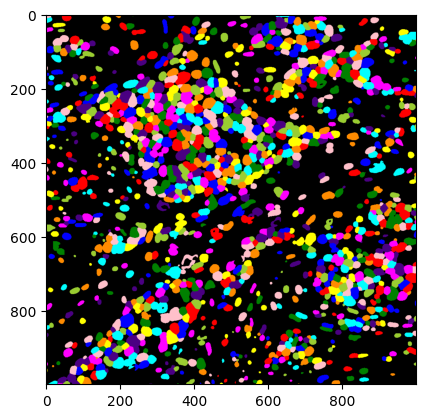

In [97]:
# visualizing a small tile
small = labeled[10000:11000, 10000:11000]
plt.imshow(label2rgb(small))

Here we extract the location and average marker intensity for each cell. We do this in batches of channels to decrease memory usage.

In [98]:
batch_size = 5 # number of channels that get processed together, decrease this number if you run into memory issues

tables = []
for i in range(0, len(channel_order), batch_size):
    print('processing channels:', channel_order[i:i + batch_size])
    
    # read in ome tif images, only the channels we need
    x = np.stack([
        tf.pages[c_idx].asarray() for c_idx in range(i, i + batch_size) if c_idx < len(channel_order)
    ])
    x = rearrange(x, 'c h w -> h w c') # channel dim needs to be last
    
    # quantify cells
    table = pd.DataFrame.from_dict(regionprops_table(
        labeled,
        x,
        properties = ['label', 'area', 'centroid', 'intensity_mean'] # you can add extra properties here if you want, like bbox, etc.
    ))
    
    # rename intensity columns
    col_mapping = {
        f'intensity_mean-{idx}':f'intensity_{c}'
        for idx, c in enumerate(channel_order[i:i + batch_size])
    }
    table.columns = [col_mapping.get(c, c) for c in table.columns]
    
    # if we aren't first, batch, we only need intensity columns
    if i != 0:
        table = table[[c for c in table.columns if c in col_mapping.values()]]
    
    tables.append(table)

feature_df = pd.concat(tables, axis=1)
feature_df

processing channels: ['DAPI', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4 (D)']
processing channels: ['CD31', 'CD4 (D)', 'SLC39A6 (D)', 'TCF-1', 'BCA1']
processing channels: ['CD68', 'CD39', 'FOXP3', 'CD163', 'PD-1']
processing channels: ['MLPH', 'CD8', 'HER2 (D)', 'GLUT1 (D)', 'ckit-(D)']
processing channels: ['Pan-Cytokeratin', 'HIF1a', 'Podoplanin (D)', 'CD20', 'HLA-DR']
processing channels: ['CK14 (D)', 'TFF1 (D)', 'MGP (D)', 'Ki67', 'Vimentin']
processing channels: ['CD3e', 'E-cadherin', 'SMA (D)', 'cd11b', 'PR (D)']
processing channels: ['CD45 (D)', 'GATA3', 'COX6C (D)']


,label,area,centroid-0,centroid-1,intensity_DAPI,intensity_Granzyme B,intensity_Keratin 5,intensity_PLAT/tPA (D),intensity_CTLA4 (D),intensity_CD31,...,intensity_Ki67,intensity_Vimentin,intensity_CD3e,intensity_E-cadherin,intensity_SMA (D),intensity_cd11b,intensity_PR (D),intensity_CD45 (D),intensity_GATA3,intensity_COX6C (D)
0,1,1853.0,9.969239,10306.740961,1.314085,0.053427,0.044792,0.240151,0.153805,0.058824,...,0.008095,0.023745,1.410685,0.008635,0.012952,0.845656,0.013492,0.046951,0.077712,0.426336
1,2,2199.0,9.659845,10486.962710,1.247385,0.060482,0.038654,0.184629,0.189632,0.061392,...,0.002729,0.016826,1.359709,0.009095,0.014552,0.881310,0.013188,0.049113,0.073670,0.386085
2,3,2191.0,9.194432,10675.613419,1.653583,0.082611,0.072570,0.367869,0.199909,0.096759,...,0.003195,0.018713,1.201278,0.013692,0.014149,0.496120,0.015518,0.066180,0.047467,0.238704
3,4,2089.0,9.161321,10865.589756,1.539493,0.099569,0.077070,0.371948,0.248444,0.096218,...,0.004308,0.019627,1.227860,0.018191,0.012925,0.532312,0.018669,0.058401,0.043562,0.258497
4,5,2376.0,9.532828,11055.005051,1.400253,0.095960,0.072811,0.364899,0.239478,0.101431,...,0.008418,0.018939,1.327441,0.025673,0.009259,0.590488,0.015993,0.060185,0.042508,0.286195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706316,706317,836.0,59613.742823,5912.912679,93.595694,0.122010,4.307416,13.545455,1.198565,0.990431,...,0.468900,26.322967,13.988038,41.668660,0.409091,6.976077,27.668660,2.235646,17.028708,5.444976
706317,706318,1033.0,59633.168441,5876.612778,17.434656,0.033882,0.591481,4.146176,0.186834,0.062924,...,0.030978,4.637948,3.867377,8.875121,0.061955,1.691191,10.114230,0.232333,1.751210,1.202323
706318,706319,684.0,59639.318713,5903.160819,35.380117,0.046784,1.441520,7.327485,0.301170,0.156433,...,1.058480,6.716374,6.285088,12.478070,0.080409,2.828947,6.573099,0.366959,6.730994,2.213450
706319,706320,408.0,59955.725490,5568.375000,1.375000,0.036765,0.051471,0.669118,0.142157,0.012255,...,0.014706,5.566176,1.806373,0.115196,0.061275,0.602941,0.066176,0.051471,0.056373,0.549020


In [99]:
# centroid-0 is y and centroid-1 is x
mapping = {'centroid-0': 'y', 'centroid-1': 'x'}
feature_df.columns = [mapping.get(c, c) for c in feature_df.columns]
feature_df

,label,area,y,x,intensity_DAPI,intensity_Granzyme B,intensity_Keratin 5,intensity_PLAT/tPA (D),intensity_CTLA4 (D),intensity_CD31,...,intensity_Ki67,intensity_Vimentin,intensity_CD3e,intensity_E-cadherin,intensity_SMA (D),intensity_cd11b,intensity_PR (D),intensity_CD45 (D),intensity_GATA3,intensity_COX6C (D)
0,1,1853.0,9.969239,10306.740961,1.314085,0.053427,0.044792,0.240151,0.153805,0.058824,...,0.008095,0.023745,1.410685,0.008635,0.012952,0.845656,0.013492,0.046951,0.077712,0.426336
1,2,2199.0,9.659845,10486.962710,1.247385,0.060482,0.038654,0.184629,0.189632,0.061392,...,0.002729,0.016826,1.359709,0.009095,0.014552,0.881310,0.013188,0.049113,0.073670,0.386085
2,3,2191.0,9.194432,10675.613419,1.653583,0.082611,0.072570,0.367869,0.199909,0.096759,...,0.003195,0.018713,1.201278,0.013692,0.014149,0.496120,0.015518,0.066180,0.047467,0.238704
3,4,2089.0,9.161321,10865.589756,1.539493,0.099569,0.077070,0.371948,0.248444,0.096218,...,0.004308,0.019627,1.227860,0.018191,0.012925,0.532312,0.018669,0.058401,0.043562,0.258497
4,5,2376.0,9.532828,11055.005051,1.400253,0.095960,0.072811,0.364899,0.239478,0.101431,...,0.008418,0.018939,1.327441,0.025673,0.009259,0.590488,0.015993,0.060185,0.042508,0.286195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706316,706317,836.0,59613.742823,5912.912679,93.595694,0.122010,4.307416,13.545455,1.198565,0.990431,...,0.468900,26.322967,13.988038,41.668660,0.409091,6.976077,27.668660,2.235646,17.028708,5.444976
706317,706318,1033.0,59633.168441,5876.612778,17.434656,0.033882,0.591481,4.146176,0.186834,0.062924,...,0.030978,4.637948,3.867377,8.875121,0.061955,1.691191,10.114230,0.232333,1.751210,1.202323
706318,706319,684.0,59639.318713,5903.160819,35.380117,0.046784,1.441520,7.327485,0.301170,0.156433,...,1.058480,6.716374,6.285088,12.478070,0.080409,2.828947,6.573099,0.366959,6.730994,2.213450
706319,706320,408.0,59955.725490,5568.375000,1.375000,0.036765,0.051471,0.669118,0.142157,0.012255,...,0.014706,5.566176,1.806373,0.115196,0.061275,0.602941,0.066176,0.051471,0.056373,0.549020


Saving the cell feature data

In [100]:
feature_df.to_csv(output_dir / f'{sid}_spatial_features.txt', sep='\t', index=False)

## Label cells based on section ID (if multiple sections on same slide)

In [101]:
ome_model = from_tiff(ome_path) # image metadata

In [102]:
# load feature data from previous step
feature_df = pd.read_csv(output_dir / f'{sid}_spatial_features.txt', sep='\t', index_col=0)
feature_df

,area,y,x,intensity_DAPI,intensity_Granzyme B,intensity_Keratin 5,intensity_PLAT/tPA (D),intensity_CTLA4 (D),intensity_CD31,intensity_CD4 (D),...,intensity_Ki67,intensity_Vimentin,intensity_CD3e,intensity_E-cadherin,intensity_SMA (D),intensity_cd11b,intensity_PR (D),intensity_CD45 (D),intensity_GATA3,intensity_COX6C (D)
label,,,,,,,,,,,,,,,,,,,,,
1,1853.0,9.969239,10306.740961,1.314085,0.053427,0.044792,0.240151,0.153805,0.058824,1.099298,...,0.008095,0.023745,1.410685,0.008635,0.012952,0.845656,0.013492,0.046951,0.077712,0.426336
2,2199.0,9.659845,10486.962710,1.247385,0.060482,0.038654,0.184629,0.189632,0.061392,1.021373,...,0.002729,0.016826,1.359709,0.009095,0.014552,0.881310,0.013188,0.049113,0.073670,0.386085
3,2191.0,9.194432,10675.613419,1.653583,0.082611,0.072570,0.367869,0.199909,0.096759,1.040621,...,0.003195,0.018713,1.201278,0.013692,0.014149,0.496120,0.015518,0.066180,0.047467,0.238704
4,2089.0,9.161321,10865.589756,1.539493,0.099569,0.077070,0.371948,0.248444,0.096218,1.067496,...,0.004308,0.019627,1.227860,0.018191,0.012925,0.532312,0.018669,0.058401,0.043562,0.258497
5,2376.0,9.532828,11055.005051,1.400253,0.095960,0.072811,0.364899,0.239478,0.101431,1.093434,...,0.008418,0.018939,1.327441,0.025673,0.009259,0.590488,0.015993,0.060185,0.042508,0.286195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706317,836.0,59613.742823,5912.912679,93.595694,0.122010,4.307416,13.545455,1.198565,0.990431,24.124402,...,0.468900,26.322967,13.988038,41.668660,0.409091,6.976077,27.668660,2.235646,17.028708,5.444976
706318,1033.0,59633.168441,5876.612778,17.434656,0.033882,0.591481,4.146176,0.186834,0.062924,6.195547,...,0.030978,4.637948,3.867377,8.875121,0.061955,1.691191,10.114230,0.232333,1.751210,1.202323
706319,684.0,59639.318713,5903.160819,35.380117,0.046784,1.441520,7.327485,0.301170,0.156433,8.402047,...,1.058480,6.716374,6.285088,12.478070,0.080409,2.828947,6.573099,0.366959,6.730994,2.213450


The easiest way to isolate the cells by their section ID is to annotate the sections on [QuPath](https://qupath.github.io/).

Watch [this video](https://wustl.box.com/s/alr735fqsxfprlmq6kkll3loast6mexk) that shows how to do the annotation for this particular slide, and how to export the geojson file that will be loaded in the following cell.

Be sure to assign a class to the section annotation that will be used as the section name/id

In [103]:
def load_regions(geojson_path):
    d = json.load(open(geojson_path))
    
    regions = d['features']
    coords = []
    for x in regions:
        try:
            coords.append(np.asarray(x['geometry']['coordinates']))
        except ValueError:
            print(x['id'], 'failed')
            coords.append(None)
    
    regions = [{
        'id': x['id'],
        'coordinates': coords[i],
        'label': x['properties']['classification']['name'],
    } for i, x in enumerate(regions) if coords[i] is not None]
    
    pixels = ome_model.images[0].pixels
    h, w = pixels.size_y, pixels.size_x
    regions = [x for x in regions if len(x['coordinates'].shape) == 3]
    for x in regions:
        x['coordinates'] = x['coordinates'][0][:, [1, 0]] # switch to y, x
        x['mask'] = skimage.draw.polygon2mask((h, w), x['coordinates']) # make binary section mask
    
    return regions

In [77]:
# these are the region annotations saved from QuPath in the previous step
geojson_path = output_dir / 'HT704B1_sections.geojson'
assert geojson_path.is_file()

Reading in the regions

In [78]:
regions = load_regions(geojson_path)
len(regions) # we have four sections

4

Displaying the regions for sanity checking purposes

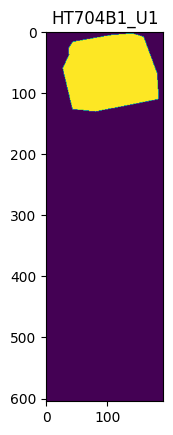

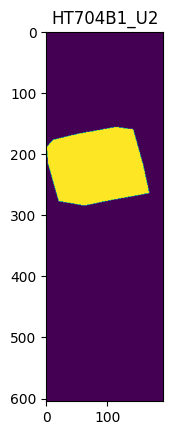

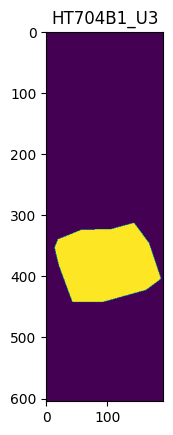

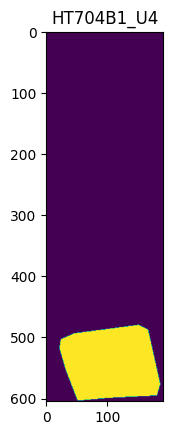

In [79]:
for x in regions:
    plt.imshow(x['mask'][::100, ::100])
    plt.title(x['label'])
    plt.show()

Now we can assign cells to a section

In [104]:
# cell coordinates
xs, ys = feature_df['x'].values.astype(int), feature_df['y'].values.astype(int)

# assign cells based on section masks
section_ids = np.full((feature_df.shape[0],), None, dtype=object)
for x in regions:
    mask = x['mask'][ys, xs]
    section_ids[mask] = x['label']

feature_df.insert(0, 'section_id', section_ids)
feature_df

,section_id,area,y,x,intensity_DAPI,intensity_Granzyme B,intensity_Keratin 5,intensity_PLAT/tPA (D),intensity_CTLA4 (D),intensity_CD31,...,intensity_Ki67,intensity_Vimentin,intensity_CD3e,intensity_E-cadherin,intensity_SMA (D),intensity_cd11b,intensity_PR (D),intensity_CD45 (D),intensity_GATA3,intensity_COX6C (D)
label,,,,,,,,,,,,,,,,,,,,,
1,None,1853.0,9.969239,10306.740961,1.314085,0.053427,0.044792,0.240151,0.153805,0.058824,...,0.008095,0.023745,1.410685,0.008635,0.012952,0.845656,0.013492,0.046951,0.077712,0.426336
2,None,2199.0,9.659845,10486.962710,1.247385,0.060482,0.038654,0.184629,0.189632,0.061392,...,0.002729,0.016826,1.359709,0.009095,0.014552,0.881310,0.013188,0.049113,0.073670,0.386085
3,None,2191.0,9.194432,10675.613419,1.653583,0.082611,0.072570,0.367869,0.199909,0.096759,...,0.003195,0.018713,1.201278,0.013692,0.014149,0.496120,0.015518,0.066180,0.047467,0.238704
4,None,2089.0,9.161321,10865.589756,1.539493,0.099569,0.077070,0.371948,0.248444,0.096218,...,0.004308,0.019627,1.227860,0.018191,0.012925,0.532312,0.018669,0.058401,0.043562,0.258497
5,None,2376.0,9.532828,11055.005051,1.400253,0.095960,0.072811,0.364899,0.239478,0.101431,...,0.008418,0.018939,1.327441,0.025673,0.009259,0.590488,0.015993,0.060185,0.042508,0.286195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706317,HT704B1_U4,836.0,59613.742823,5912.912679,93.595694,0.122010,4.307416,13.545455,1.198565,0.990431,...,0.468900,26.322967,13.988038,41.668660,0.409091,6.976077,27.668660,2.235646,17.028708,5.444976
706318,HT704B1_U4,1033.0,59633.168441,5876.612778,17.434656,0.033882,0.591481,4.146176,0.186834,0.062924,...,0.030978,4.637948,3.867377,8.875121,0.061955,1.691191,10.114230,0.232333,1.751210,1.202323
706319,HT704B1_U4,684.0,59639.318713,5903.160819,35.380117,0.046784,1.441520,7.327485,0.301170,0.156433,...,1.058480,6.716374,6.285088,12.478070,0.080409,2.828947,6.573099,0.366959,6.730994,2.213450


And we can visualize the cells by section id

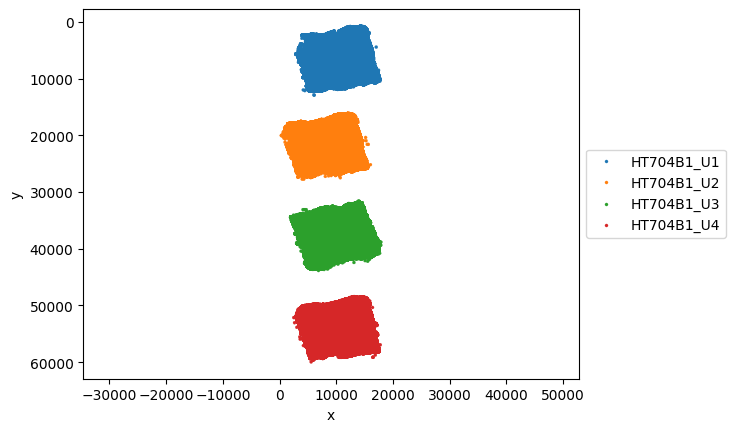

In [93]:
sns.scatterplot(feature_df, x='x', y='y', hue='section_id', s=5, edgecolors=None)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

Save the section_id annotated cell feature data

In [105]:
feature_df.to_csv(output_dir / f'{sid}_section_level_spatial_features.txt', sep='\t', index=True)

## Cell typing

This cell typing will be based on a basic single cell annotation workflow.

If you want to assign cell types via gates, I recommend you look at either [this notebook](https://github.com/estorrs/imaging-analysis/blob/main/notebooks/brca_subtype/old/step_2_generate_spatial_features.ipynb), or ask Julia Wang, she also has a gating workflow. Sometimes clustering only works well for general cell types. If you are doing very specific cell types usually you need some combination of gating or clustering + gating.

In [111]:
feature_df = pd.read_csv(
    output_dir / f'{sid}_section_level_spatial_features.txt',
    sep='\t', index_col=0
)
feature_df

,section_id,area,y,x,intensity_DAPI,intensity_Granzyme B,intensity_Keratin 5,intensity_PLAT/tPA (D),intensity_CTLA4 (D),intensity_CD31,...,intensity_Ki67,intensity_Vimentin,intensity_CD3e,intensity_E-cadherin,intensity_SMA (D),intensity_cd11b,intensity_PR (D),intensity_CD45 (D),intensity_GATA3,intensity_COX6C (D)
label,,,,,,,,,,,,,,,,,,,,,
1,NaN,1853.0,9.969239,10306.740961,1.314085,0.053427,0.044792,0.240151,0.153805,0.058824,...,0.008095,0.023745,1.410685,0.008635,0.012952,0.845656,0.013492,0.046951,0.077712,0.426336
2,NaN,2199.0,9.659845,10486.962710,1.247385,0.060482,0.038654,0.184629,0.189632,0.061392,...,0.002729,0.016826,1.359709,0.009095,0.014552,0.881310,0.013188,0.049113,0.073670,0.386085
3,NaN,2191.0,9.194432,10675.613419,1.653583,0.082611,0.072570,0.367869,0.199909,0.096759,...,0.003195,0.018713,1.201278,0.013692,0.014149,0.496120,0.015518,0.066180,0.047467,0.238704
4,NaN,2089.0,9.161321,10865.589756,1.539493,0.099569,0.077070,0.371948,0.248444,0.096218,...,0.004308,0.019627,1.227860,0.018191,0.012925,0.532312,0.018669,0.058401,0.043562,0.258497
5,NaN,2376.0,9.532828,11055.005051,1.400253,0.095960,0.072811,0.364899,0.239478,0.101431,...,0.008418,0.018939,1.327441,0.025673,0.009259,0.590488,0.015993,0.060185,0.042508,0.286195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706317,HT704B1_U4,836.0,59613.742823,5912.912679,93.595694,0.122010,4.307416,13.545455,1.198565,0.990431,...,0.468900,26.322967,13.988038,41.668660,0.409091,6.976077,27.668660,2.235646,17.028708,5.444976
706318,HT704B1_U4,1033.0,59633.168441,5876.612778,17.434656,0.033882,0.591481,4.146176,0.186834,0.062924,...,0.030978,4.637948,3.867377,8.875121,0.061955,1.691191,10.114230,0.232333,1.751210,1.202323
706319,HT704B1_U4,684.0,59639.318713,5903.160819,35.380117,0.046784,1.441520,7.327485,0.301170,0.156433,...,1.058480,6.716374,6.285088,12.478070,0.080409,2.828947,6.573099,0.366959,6.730994,2.213450


Here we make a scanpy adata object

In [113]:
# pull marker intensity columns
marker_cols = [c for c in feature_df.columns if 'intensity_' in c]

# create anndata object
adata = anndata.AnnData(
    X=feature_df[marker_cols].values,
    obs=feature_df[[c for c in feature_df.columns if c not in marker_cols]]
)
adata.var.index = [c.replace('intensity_', '') for c in marker_cols]
adata.raw = adata

adata

/diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 706321 × 38
    obs: 'section_id', 'area', 'y', 'x'

In [115]:
# filter out cells that dont belong to a section
adata = adata[~pd.isnull(adata.obs['section_id'])]
adata

View of AnnData object with n_obs × n_vars = 706036 × 38
    obs: 'section_id', 'area', 'y', 'x'

Scaling the expression

In [116]:
sc.pp.scale(adata)
adata

/diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 706036 × 38
    obs: 'section_id', 'area', 'y', 'x'
    var: 'mean', 'std'

Running harmony to integrate (only necessary if you have multiple sections on the slide)

In [121]:
sc.pp.pca(adata, n_comps=10)
sce.pp.harmony_integrate(adata, 'section_id', max_iter_harmony=2)
adata

2025-09-09 15:49:26,526 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-09 15:50:09,582 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-09 15:50:12,929 - harmonypy - INFO - Iteration 1 of 2
2025-09-09 15:53:54,478 - harmonypy - INFO - Iteration 2 of 2
2025-09-09 15:57:59,154 - harmonypy - INFO - Stopped before convergence


AnnData object with n_obs × n_vars = 706036 × 38
    obs: 'section_id', 'area', 'y', 'x'
    var: 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

Computing k-means clusters from the harmony components

In [124]:
clf = KMeans(n_clusters=25)
preds = clf.fit_predict(adata.obsm['X_pca_harmony'])
adata.obs['cluster'] = [str(x) for x in preds]

we can plot clusters back to the cells

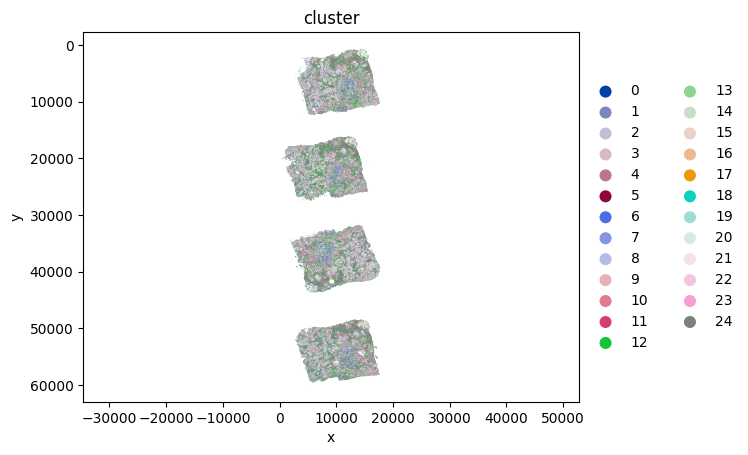

In [127]:
fig, ax = plt.subplots()
sc.pl.scatter(adata, x='x', y='y', color='cluster', ax=ax, show=False)
ax.axis('equal')
ax.invert_yaxis()

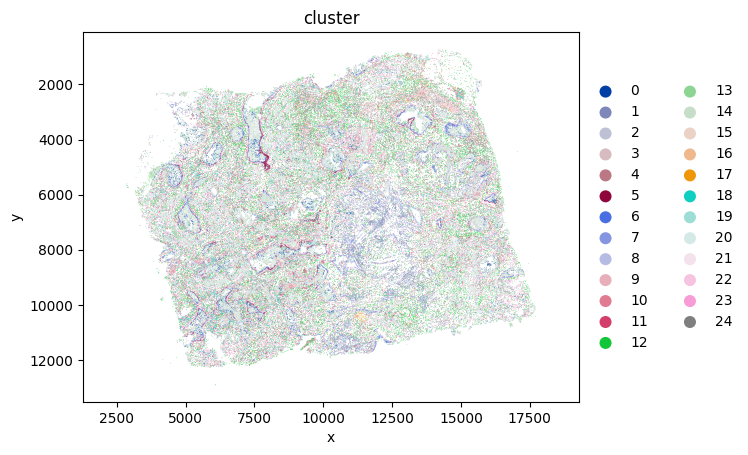

In [128]:
# selecting one section for a zoomed in look
section_ids = sorted(set(adata.obs['section_id']))
section_id = section_ids[0]
f = adata[[x == section_id for x in adata.obs['section_id']]]

fig, ax = plt.subplots()
sc.pl.scatter(f, x='x', y='y', color='cluster', ax=ax, show=False)
ax.axis('equal')
ax.invert_yaxis()

heatmap with some cell typing genes

In [129]:
adata.var.index # the markers for our run

Index(['DAPI', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4 (D)', 'CD31',
       'CD4 (D)', 'SLC39A6 (D)', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3',
       'CD163', 'PD-1', 'MLPH', 'CD8', 'HER2 (D)', 'GLUT1 (D)', 'ckit-(D)',
       'Pan-Cytokeratin', 'HIF1a', 'Podoplanin (D)', 'CD20', 'HLA-DR',
       'CK14 (D)', 'TFF1 (D)', 'MGP (D)', 'Ki67', 'Vimentin', 'CD3e',
       'E-cadherin', 'SMA (D)', 'cd11b', 'PR (D)', 'CD45 (D)', 'GATA3',
       'COX6C (D)'],
      dtype='object')

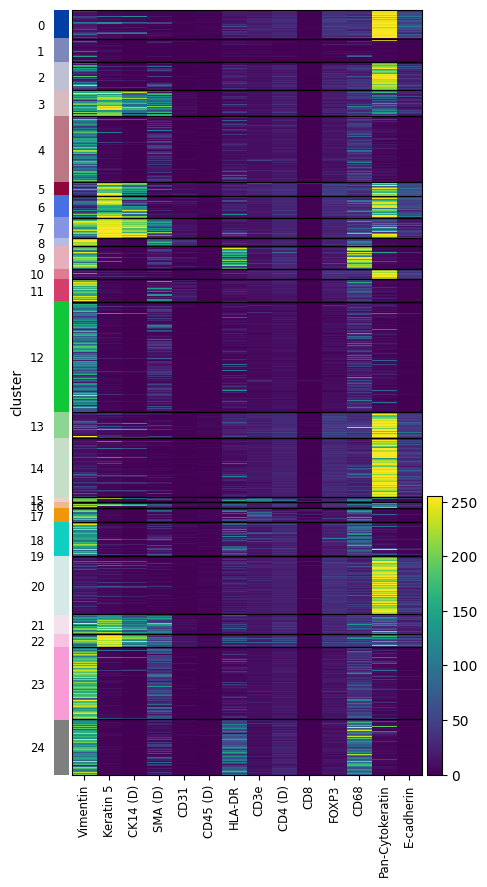

In [140]:
genes = [
    'Vimentin',
    'Keratin 5',
    'CK14 (D)',
    'SMA (D)',
    'CD31',
    'CD45 (D)',
    'HLA-DR',
    'CD3e',
    'CD4 (D)',
    'CD8',
    'FOXP3',
    'CD68',
    'Pan-Cytokeratin',
    'E-cadherin',
]

sc.pl.heatmap(adata, [g for g in genes if g in adata.var.index], groupby='cluster', figsize=(5, 10))

Here we assign clusters to cell types. (if you get an index error it probably means you haven't assigned all clusters)

In [144]:
mapping = {
    'Epithelial': [0, 2, 5, 6, 10, 13, 14, 20],
    'Basal': [3, 5, 6, 7, 16, 21, 22],
    'T cell': [15],
    'Fibroblast': [4, 11, 23],
    'Macrophage': [9, 24],
    'Endothelial': [8],
    'Unknown': [1, 12, 17, 18, 19],
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
adata.obs['cell_type'] = [r_mapping[int(x)] for x in adata.obs['cluster']]

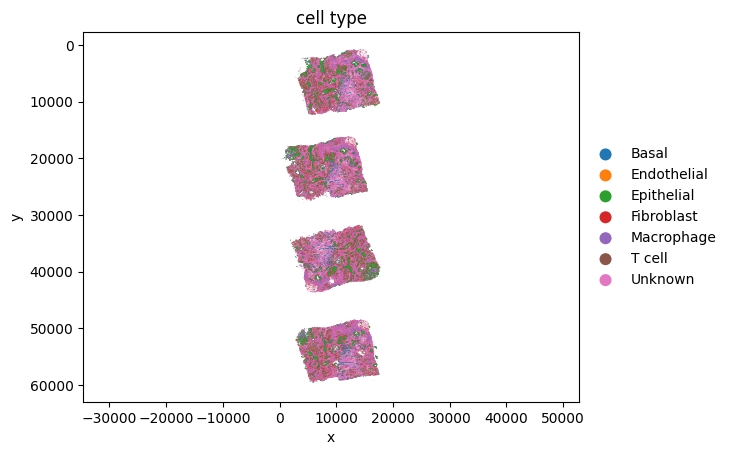

In [145]:
fig, ax = plt.subplots()
sc.pl.scatter(adata, x='x', y='y', color='cell_type', ax=ax, show=False)
ax.axis('equal')
ax.invert_yaxis()

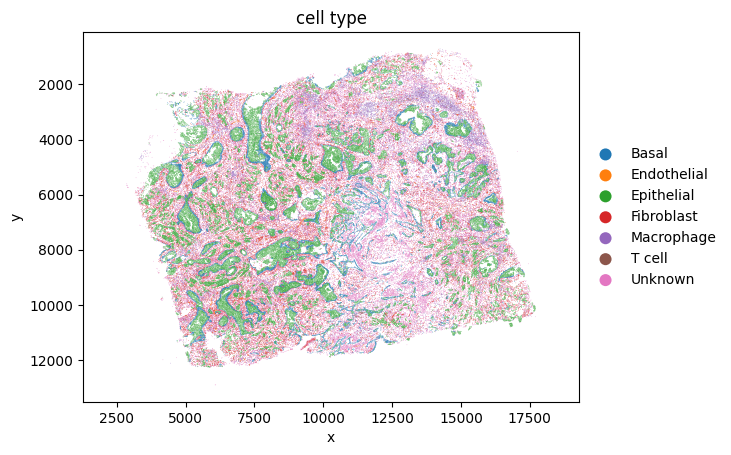

In [146]:
f = adata[[x == section_id for x in adata.obs['section_id']]]

fig, ax = plt.subplots()
sc.pl.scatter(f, x='x', y='y', color='cell_type', ax=ax, show=False)
ax.axis('equal')
ax.invert_yaxis()

Saving scanpy anndata object

In [148]:
adata.write_h5ad(output_dir / f'{sid}_annotated_features.h5ad')

We can also just save the metadata

In [150]:
adata.obs.to_csv(output_dir / f'{sid}_annotated_features.txt', sep='\t')

Again, if you want to cell type on more specific markers, I recommend picking a threshold and then gating cells on that particular marker. This type of clustering usually only yields general clusters

## Visualizing cell types in other image viewers

We can also create an OME-TIF that has embedded cell type information, so that you can view your cell type calls in something like QuPath

To do so, we add extra image channels to the OME-TIF that are binary masks, where we give pixels that are a certain cell type a value of 255 and pixels that are not a value of 0

First, we load in the cell annotations, segmentation file, and original OME-TIF

In [4]:
adata = sc.read_h5ad(output_dir / f'{sid}_annotated_features.h5ad')
adata

AnnData object with n_obs × n_vars = 706036 × 38
    obs: 'section_id', 'area', 'y', 'x', 'cluster', 'cell_type'
    var: 'mean', 'std'
    uns: 'cell_type_colors', 'cluster_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# labeled tif that delineates cells
seg_path = output_dir / f'{sid}_cell_segmentation.tif'
assert seg_path.is_file()

# ome tif with marker intensities
ome_path = output_dir / f'{sid}.ome.tiff'
assert ome_path.is_file()

In [7]:
tf = tifffile.TiffFile(ome_path)

ome_model = from_tiff(ome_path)
pixels = ome_model.images[0].pixels
channel_order = [c.name for c in pixels.channels]
len(channel_order)

38

In [8]:
set(adata.obs['cell_type'])

{'Basal',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'Macrophage',
 'T cell',
 'Unknown'}

In [10]:
labeled_img = tifffile.imread(seg_path)
labeled_img.shape

(60480, 19200)

For each channel, we will add an additional channel to the image, where we give pixels belonging to that cell type 255

In [13]:
ct_data = []
cell_types = sorted(set(adata.obs['cell_type']))
ct_data = np.zeros((len(cell_types), *labeled_img.shape), dtype=np.uint8)

for i, cell_type in enumerate(cell_types):
    print(cell_type)
    filtered = adata[adata.obs['cell_type'] == cell_type]
    labels = filtered.obs.index.to_numpy().astype(int)
    mask = np.isin(labeled_img, labels)

    ct_data[i][mask] = 255

ct_data.shape

Basal
Endothelial
Epithelial
Fibroblast
Macrophage
T cell
Unknown


(7, 60480, 19200)

In [14]:
# we can now add it to the original OME-TIF

combined_data = np.concat((tifffile.imread(ome_path), ct_data))
combined_channels = [*channel_order, *cell_types]

combined_data.shape, len(combined_channels)

((45, 60480, 19200), 45)

In [16]:
def write_ome_tif(output_fp, data, channel_names, mpp, subresolutions=4):
    """
    Writes a pyramidal OME-TIF.

    We can use this function to save multiplex images we have manipulated and want to resave.

    output_fp - where to write the ome-tif
    data - pixel data, should be (c, h, w)
    ome_model - OME model, should be created with ome-types
    subresolution - number of pyramid resolutions to write
    """
    assert len(channel_names) == data.shape[0]
    # creating OME model
    ome_model = OME(
        images=[
            Image(
                pixels=Pixels(
                    dimension_order='XYCZT',
                    type='uint8',
                    physical_size_x_unit='µm',
                    physical_size_y_unit='µm',
                    physical_size_x=mpp,
                    physical_size_y=mpp,
                    size_c=len(channel_names),
                    size_t=1,
                    size_x=data.shape[-1],
                    size_y=data.shape[-2],
                    size_z=1,
                    
                    channels=[
                        Channel(name=name) for name in channel_names
                    ]
                )
            )
        ]
    )
    
    with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
        opts = {
            'compression': 'LZW',
        }
        out_tif.write(
            data,
            subifds=subresolutions,
            **opts
        )
        for level in range(subresolutions):
            mag = 2**(level + 1)
            out_tif.write(
                data[:, ::mag, ::mag],
                subfiletype=1,
                **opts
            )
        xml_str = to_xml(ome_model)
        out_tif.overwrite_description(xml_str.encode())

Writing the altered OME-TIF

In [19]:
mpp = pixels.physical_size_x # grabbing resolution of the image

altered_ome_path = '../data/20240705_Human_BRCA_HT704B1_CODEX_1/cell_type_altered.ome.tiff'
write_ome_tif(altered_ome_path, combined_data, combined_channels, mpp, subresolutions=4)

Building off this, we can also save other types of altered multiplex images.

For instance, setting all pixels where the cell type is unknown to 0

In [22]:
idx = combined_channels.index('Unknown')
mask = combined_data[idx] > 0

combined_data[:-1, mask] = 0

In [30]:
altered_ome_path = '../data/20240705_Human_BRCA_HT704B1_CODEX_1/mask_altered.ome.tiff'
write_ome_tif(altered_ome_path, combined_data, combined_channels, mpp, subresolutions=4)